# **CONNECION WITH GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **IMPORT LIBRARIES**

In [ ]:
!pip install geopandas
!pip install networkx
!pip install osmnx
!pip install geopandas partridge shapely folium
!pip install geopandas transliterate
!pip install partridge pandas
!pip install geopandas mapclassify matplotlib

In [ ]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import pandas as pd
import partridge as ptg
import os
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np
from mapclassify import JenksCaspall
from shapely.geometry import Point, Polygon
from shapely.geometry import Point, LineString
from transliterate import translit

# **READ CITY CENTERS FROM DRIVE**

In [ ]:
# Load the shapefile with city centers
city_centers = gpd.read_file('/content/drive/My Drive/paper_amari/shp/oikismoi_amari.shp')

#If the column with settlement names is not with English character transliterate them

# Define the column with settlements names with Greek characters
greek_column = 'OIKISMOS'

# Transliterate Greek characters to English in the specified column
city_centers[greek_column] = city_centers[greek_column].apply(lambda x: translit(x, 'el', reversed=True) if isinstance(x, str) else x)

# Optionally, save as a Shapefile if needed
output_path_shp = '/content/output_file_transliterated.shp'
city_centers.to_file(output_path_shp, driver='ESRI Shapefile')


# **DOWNLOAD ROAD NETWORK FROM OPEN STREET MAP (OSM)**

In [ ]:
# Define the area of interest as a polygon using coordinates (longitude, latitude)
area_polygon = Polygon([
    (24.5430, 35.3081),
    (24.5430, 35.0982),
    (24.8142, 35.0982),
    (24.8142, 35.3081)
])

In [ ]:
# Download the road network for the area inside the polygon
G = ox.graph_from_polygon(area_polygon, network_type='all')

# You can change 'walk' to 'drive', 'bike', or 'all' depending on your network type.


In [ ]:
# Convert the road network to a GeoDataFrame for nodes and edges
nodes, edges = ox.graph_to_gdfs(G)

# Save the edges (road network) to a shapefile
edges.to_file('road_network.shp')

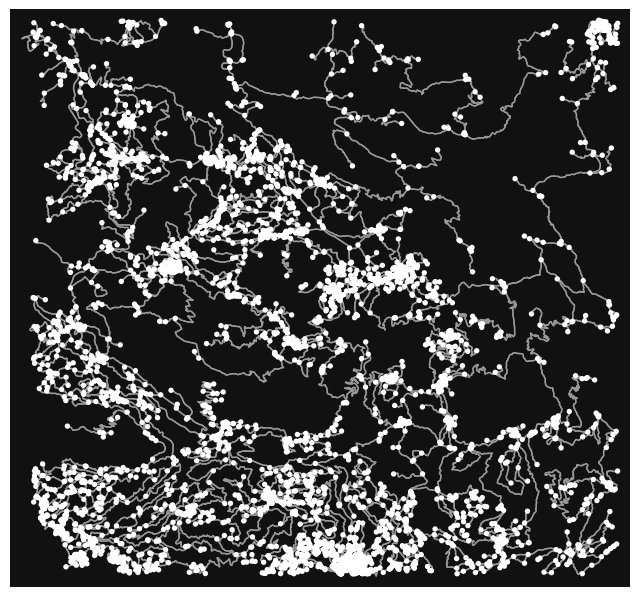

In [ ]:
# Plot the graph (road network)
ox.plot_graph(G)
plt.show()

# **SET SPEED AND DISTANCE**

In [ ]:
# Set walking speed (meters per minute)
walking_speed = 80  # average walking speed: 80 meters/minute
time_limit = 15  # walking time in minutes
distance_limit = walking_speed * time_limit  # 15-minute walk = 1200 meters

In [ ]:
# Get the CRS of the road network and project the city centers to match it
nodes, edges = ox.graph_to_gdfs(G)
road_network_crs = nodes.crs  # Get the CRS of the nodes GeoDataFrame
city_centers = city_centers.to_crs(road_network_crs)

# **CREATE ISOCHRONES FROM CITY CENTERS**

In [ ]:
# Function to calculate isochrone from each city center point
isochrones = []
for idx, city in city_centers.iterrows():
    # Get the city center point as (latitude, longitude)
    center_point = (city.geometry.y, city.geometry.x)

    # Find the nearest road network node to the city center
    nearest_node = ox.distance.nearest_nodes(G, X=center_point[1], Y=center_point[0])

    # Create subgraph of all reachable nodes within the walking distance (1200 meters)
    subgraph = nx.ego_graph(G, nearest_node, radius=distance_limit, distance='length')

    # Get node coordinates and create a convex hull polygon
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    if node_points:
        isochrone_polygon = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrones.append({'city': city['OIKISMOS'], 'geometry': isochrone_polygon})

<ipython-input-11-3ad003436355>:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polygon = gpd.GeoSeries(node_points).unary_union.convex_hull
<ipython-input-11-3ad003436355>:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polygon = gpd.GeoSeries(node_points).unary_union.convex_hull
<ipython-input-11-3ad003436355>:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polygon = gpd.GeoSeries(node_points).unary_union.convex_hull
<ipython-input-11-3ad003436355>:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polygon = gpd.GeoSeries(node_points).unary_union.convex_hull
<ipython-input-11-3ad003436355>:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polygon = g

In [ ]:
# Convert list of isochrones to a GeoDataFrame
isochrones_gdf = gpd.GeoDataFrame(isochrones, crs=city_centers.crs)

In [ ]:
# Save the isochrones to a shapefile
isochrones_gdf.to_file('15_minute_walking_isochrones.shp')

# **APPLY BUFFER ON ROAD NETWORK**

In [ ]:
# Load the shapefile with city centerroad networks
road_network = gpd.read_file('/content/drive/My Drive/paper_amari/shp/road_network.shp')

In [ ]:
# Reproject to Web Mercator (EPSG 3857) or your specific UTM zone
gdf_utm = road_network.to_crs(epsg=4326)

In [ ]:
# Create the buffer with a distance of 150 meters
road_network_buffer = road_network.buffer(0.0020)

<ipython-input-16-81146eb7db47>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_network_buffer = road_network.buffer(0.0020)


<ipython-input-17-0b15d86cc06b>:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


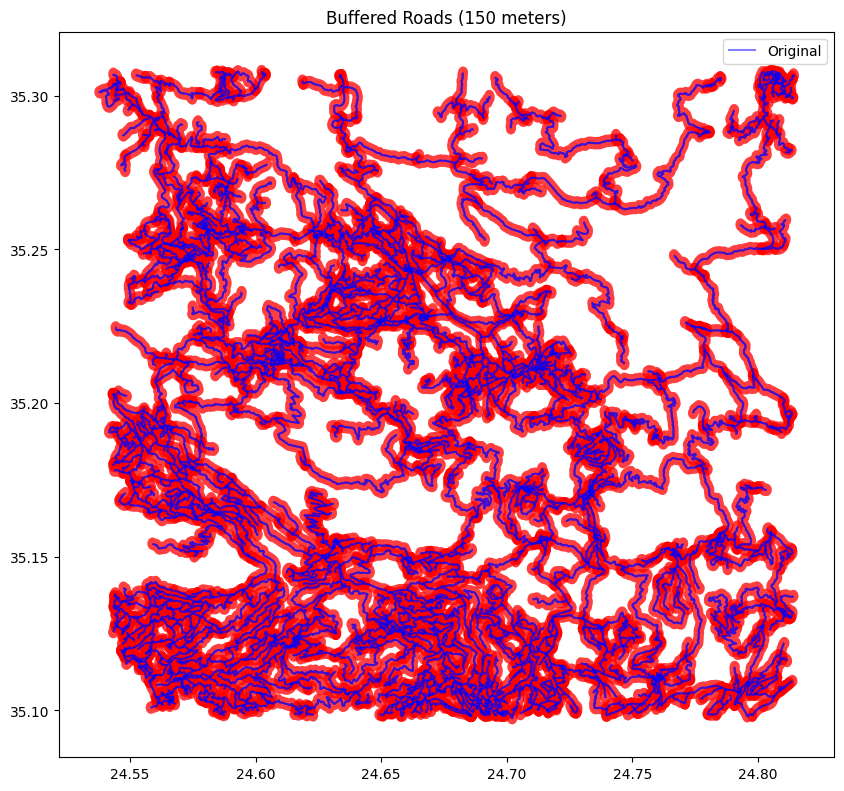

In [ ]:
# Plot both the original and buffered geometries
fig, ax = plt.subplots(figsize=(10, 10))

# Plot original shapefile (in blue)
gdf_utm.plot(ax=ax, color='blue', label='Original', alpha=0.5)

# Plot buffer (in red)
gpd.GeoDataFrame(geometry=road_network_buffer).plot(ax=ax, color='red', label='Buffer', alpha=0.5)

# Add title and legend
ax.set_title('Buffered Roads (150 meters)')
plt.legend()

plt.show()

In [ ]:
# Save buffered shapefile
road_network_buffer.to_file('buffered_road_network.shp')

# **SELECT POINTS OF INTEREST WHITHIN ISOCHRONES**

In [ ]:
# Load the isochrones polygons and points of interest layers
gdf_polygons = gpd.read_file('/content/drive/My Drive/paper_amari/shp/15_minute_walking_isochrones.shp')
gdf_points = gpd.read_file('/content/drive/My Drive/paper_amari/shp/pois_amari.shp')

In [ ]:
# Convert to WGS84 (EPSG:4326)
gdf_points_wgs84 = gdf_points.to_crs(epsg=4326)

In [ ]:
# Ensure both layers are in the same CRS
if gdf_polygons.crs != gdf_points.crs:
    gdf_polygons = gdf_polygons.to_crs(gdf_points.crs)

In [ ]:
# Save the converted points to a new shapefile (or any other format)
gdf_points_wgs84.to_file('converted_poi_wgs84.shp')

In [ ]:
# Find points that are within the polygons using the 'within' method
points_within_polygons = gdf_points[gdf_points.geometry.apply(lambda point: any(point.within(polygon) for polygon in gdf_polygons.geometry))]


In [ ]:
# Check if there are any points found
if not points_within_polygons.empty:
    print(f"Number of points found: {len(points_within_polygons)}")

    # Save the filtered points that are within polygons to a new shapefile
    points_within_polygons.to_file('points_within_polygons.shp', driver='ESRI Shapefile')

else:
    print("No points were found within the polygons.")

Number of points found: 23


In [ ]:
# Load the shapefiles
isochrones = gpd.read_file('/content/15_minute_walking_isochrones.shp')
services = gpd.read_file('/content/points_within_polygons.shp')

In [ ]:
# Ensure the CRS matches between both GeoDataFrames
services = services.to_crs(isochrones.crs)

# Check for null values in the village names column
print(isochrones['city'].isnull().sum())  # Adjust 'city' to your column name
print(isochrones['city'].unique())  # To see all unique names, including None

# Fill null values with a placeholder (optional)
isochrones['city'] = isochrones['city'].fillna('Unknown Village')

# Perform the spatial join
joined_data = gpd.sjoin(services, isochrones, predicate='within', how='right')

# Group by village name and count the services
service_counts = (
    joined_data.groupby('city')['Name']  # Replace 'city' with the actual village name column
    .count()
    .reindex(isochrones['city'].unique(), fill_value=0)  # Ensure all villages are included
)


0
['Platanos,o' 'Agia Paraskeui,i' 'Apodoyloy,to' 'Lochria,i' 'Nithauris,i'
 '’gios Ioannis,o' '’no Meros,to' 'Koyroytai,ai' 'Vrysai,ai'
 'Petrochorion,to' 'Vizarion,to' 'Foyrfoyras,o' 'Gerakarion,to'
 'Labiotai,oi' 'Elenai,ai' 'Amarion,to' 'Monastirakion,to' 'Platania,ta'
 'Meronas,o' 'Patsos,o' 'Vistagi,i' 'Apostoloi,oi' 'Agia Foteini,i'
 'Kalogeros,o' 'Pantanassa,i' 'Thronos,o' 'Voleones,oi' 'Mandres,oi'
 'Rizikas,o' 'Sata,i' '’rdaktos,o' 'Vathiakon,to' 'Genna,i' 'Opsigias,o'
 'Drugiai,ai' 'Chordakion,to' 'Moni Asomaton,i' 'Kardakion,to'
 'Mesonisia,ta' 'Klisidion,to']


In [ ]:
# Replace "?" with "A" in the village names
service_counts.index = service_counts.index.str.replace('?', 'A')

# Remove commas and everything after them in the village names
service_counts.index = service_counts.index.str.replace(r',.*', '', regex=True)

# Sort the service counts by the village names in alphabetical order
service_counts = service_counts.sort_index()

In [ ]:
# Convert the counts into a DataFrame with village names as columns
services_table = pd.DataFrame([service_counts.values], columns=service_counts.index)

# Rename the index to indicate it represents service counts
services_table.index = ['service_count']

# View the final table
print(services_table)

# # Optionally save to CSV or another format
services_table.to_csv('/content/services_table.csv')

# from google.colab import files
# files.download('/content/services_table.csv')

city           Agia Foteini  Agia Paraskeui  Amarion  Apodoyloy  Apostoloi  \
service_count             6               0        0          1          6   

city           Chordakion  Drugiai  Elenai  Foyrfoyras  Genna  ...  Sata  \
service_count           0        0       0           7      2  ...     0   

city           Thronos  Vathiakon  Vistagi  Vizarion  Voleones  Vrysai  \
service_count        1          0        0         2         0       0   

city           ’gios Ioannis  ’no Meros  ’rdaktos  
service_count              0          0         0  

[1 rows x 40 columns]


In [ ]:
# Create a new DataFrame with only one row containing the numbers and no column names
num_services = pd.DataFrame([service_counts.values])

# Rename the index for clarity
num_services.index = ['service_count']

# View the new table to verify
print(num_services)

# Save `num_services` to a CSV file if needed
num_services.to_csv('/content/num_services.csv', header=False, index=False)

# Displaying the file path for download
print("CSV file saved as /content/num_services.csv")

# Download the CSV file directly to your local machine
# from google.colab import files
# files.download('/content/num_services.csv')


               0   1   2   3   4   5   6   7   8   9   ...  30  31  32  33  \
service_count   6   0   0   1   6   0   0   0   7   2  ...   0   1   0   0   

               34  35  36  37  38  39  
service_count   2   0   0   0   0   0  

[1 rows x 40 columns]
CSV file saved as /content/num_services.csv


# **GTFS**

In [ ]:
# Path to your GTFS file
gtfs_path = "/content/drive/My Drive/paper_amari/gtfs_amari.zip"  # Adjust the path if needed

# Read the GTFS data using partridge
feed = ptg.load_feed(gtfs_path, view=None)

# Access the data as individual pandas DataFrames
routes = feed.routes
trips = feed.trips
stops = feed.stops
stop_times = feed.stop_times
calendar = feed.calendar


In [ ]:
# Extract the GTFS tables
trips = feed.trips
stop_times = feed.stop_times
stops = feed.stops
calendar = feed.calendar

# List of stops you're interested in
selected_stops = [
    "Agia Foteini", "Agia Paraskevi", "Agios Ioannis", "Amari", "Ano Meros", "Apodoulou",
    "Apostoloi", "Ardaktos", "Chordaki", "Drigies", "Elenes", "Fourfouras", "Genna",
    "Gerakari", "Kalogeros", "Kardaki", "Klisidi", "Kouroutes", "Lampiotes", "Lochria",
    "Mandres", "Meronas", "Mesonisia", "Monastiraki", "Moni Asomaton", "Nithauris",
    "Opsigias", "Pantanassa", "Patsos", "Petrochori", "Platania", "Platanos", "Rizikas",
    "Sata", "Thronos", "Vathiaki", "Vistagi", "Vizari", "Voliones", "Vrises"
]

In [ ]:
# Join stop_times with stops to get stop names
stop_times_with_names = stop_times.merge(stops[['stop_id', 'stop_name']], on='stop_id', how='left')
stop_times_with_names = stop_times_with_names[['trip_id', 'stop_id', 'stop_sequence', 'stop_name']]

# Filter for selected stops
filtered_stop_times = stop_times_with_names[stop_times_with_names['stop_name'].isin(selected_stops)]

# Self-join to get Origin-Destination pairs for each trip
od_pairs = filtered_stop_times.merge(
    filtered_stop_times,
    on='trip_id',
    suffixes=('_origin', '_destination')
)
# Ensure the origin stop comes before the destination stop in sequence
od_pairs = od_pairs[od_pairs['stop_sequence_origin'] < od_pairs['stop_sequence_destination']]

# Join with trips and calendar data to get service information
od_with_service = od_pairs.merge(trips, on='trip_id', how='left').merge(calendar, on='service_id', how='left')

In [ ]:
# Summarize weekly trips between the selected stops
od_weekly = od_with_service.groupby(['stop_name_origin', 'stop_name_destination']).agg(
    weekly_trips=pd.NamedAgg(
        column='monday',
        aggfunc=lambda x: x.sum() + od_with_service['tuesday'].sum() +
                          od_with_service['wednesday'].sum() + od_with_service['thursday'].sum() +
                          od_with_service['friday'].sum() + od_with_service['saturday'].sum() +
                          od_with_service['sunday'].sum()
    )
).reset_index()


In [ ]:
# Calculate weekly trips by summing the days of the week for each O-D pair
od_with_service['weekly_trips'] = od_with_service[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum(axis=1)
od_weekly = od_with_service.groupby(['stop_name_origin', 'stop_name_destination'], as_index=False)['weekly_trips'].sum()

# Ensure there are no missing values
od_weekly['weekly_trips'] = od_weekly['weekly_trips'].fillna(0)



In [ ]:
# Step 1: Create all possible O-D pairs (including self-pairs)
all_od_pairs = pd.DataFrame(itertools.product(selected_stops, selected_stops), columns=['stop_name_origin', 'stop_name_destination'])

In [ ]:
# Step 2: Left join the summarized weekly trips to the full set of O-D pairs
od_complete = all_od_pairs.merge(od_weekly, on=['stop_name_origin', 'stop_name_destination'], how='left')
od_complete['weekly_trips'] = od_complete['weekly_trips'].fillna(0)  # Set missing trips to 0

In [ ]:
# Step 3: Create a symmetric matrix for each O-D pair

# Merge od_complete with itself to get forward and reverse pairs
od_symmetric = pd.merge(
    od_complete,
    od_complete,
    left_on=["stop_name_origin", "stop_name_destination"],
    right_on=["stop_name_destination", "stop_name_origin"],
    suffixes=('_forward', '_reverse'),
    how='outer'
)

# Fill NaN values in the trip columns with 0 for both directions
od_symmetric['weekly_trips_forward'] = od_symmetric['weekly_trips_forward'].fillna(0)
od_symmetric['weekly_trips_reverse'] = od_symmetric['weekly_trips_reverse'].fillna(0)

# Sum the trips in both directions
od_symmetric['weekly_trips'] = od_symmetric['weekly_trips_forward'] + od_symmetric['weekly_trips_reverse']

# Select the original columns plus the new forward and reverse columns
od_symmetric = od_symmetric[[ 'stop_name_origin_forward', 'stop_name_destination_forward',  'weekly_trips']]

od_symmetric = od_symmetric.rename(columns={
    'stop_name_origin_forward': 'stop_name_origin',
    'stop_name_destination_forward': 'stop_name_destination'
})


In [ ]:
# Step 4: Pivot to create the O-D matrix in wide format, ensuring correct row/column order
od_matrix_symmetric = od_symmetric.pivot(index='stop_name_origin', columns='stop_name_destination', values='weekly_trips').fillna(0)
od_matrix_symmetric = od_matrix_symmetric.reindex(index=selected_stops, columns=selected_stops, fill_value=0).reset_index()



In [ ]:
# Assuming od_matrix_symmetric has a column 'stop_name_origin' as the first column
# Remove the first column (stop names) and convert the DataFrame to a NumPy matrix
stop_names = od_matrix_symmetric['stop_name_origin']  # Extract the stop names
od_matrix = od_matrix_symmetric.iloc[:, 1:].to_numpy()  # Convert remaining columns to NumPy array

# Set the diagonal elements to 5
np.fill_diagonal(od_matrix, 5)

# Set all values in the matrix that exceed 5 to exactly 5
od_matrix = np.minimum(od_matrix, 5)

# Convert the modified matrix back to a DataFrame, with the stop names as the first column
od_matrix_symmetric = pd.DataFrame(od_matrix, columns=od_matrix_symmetric.columns[1:])
od_matrix_symmetric.insert(0, 'stop_name', stop_names)  # Add stop names as the first column


# **ACCESSIBILITY**

In [ ]:
# Load the land uses CSV file
landuses = num_services

# # Transpose the land uses table
# landuses_transposed = landuses.T

# Assuming od_matrix_symmetric is a DataFrame loaded or created previously,
# convert it to a matrix excluding the first column if it contains non-numeric data
freq = od_matrix_symmetric.iloc[:, 1:].values  # Adjust if needed

# Flatten the transposed land uses matrix into a vector
Uses = landuses.values.flatten()

# Calculate the cross-product of freq and Uses
sumproduct = np.dot(freq, Uses)

# Convert sumproduct to a DataFrame
Access_Final = pd.DataFrame(sumproduct, columns=["Accessibility"])

# Display the final accessibility DataFrame
print(Access_Final)

# # Save to CSV if needed
# Access_Final.to_csv('/content/Access_Final.csv', index=False)

    Accessibility
0            77.0
1             0.0
2             0.0
3            17.0
4            60.0
5            31.0
6            42.0
7            31.0
8            35.0
9            48.0
10           51.0
11           47.0
12            0.0
13           45.0
14           17.0
15           48.0
16           47.0
17           31.0
18           17.0
19           31.0
20            0.0
21           42.0
22           45.0
23           13.0
24           47.0
25           31.0
26           17.0
27           42.0
28           42.0
29           13.0
30            0.0
31           33.0
32            0.0
33            0.0
34           47.0
35           31.0
36           13.0
37           47.0
38           21.0
39           42.0


In [ ]:
# Load settlements data
settlements = pd.read_csv('/content/test3.csv')

# Create Access_Final_settl by adding population data from settlements
Access_Final_settl = Access_Final.copy()
Access_Final_settl['pop'] = settlements['pop_2011']

# Add the 'id' column from settlements to Access_Final_settl
Access_Final_settl = pd.concat([Access_Final_settl, settlements[['id']]], axis=1)
Access_Final_settl.columns = ['Accessibility', 'pop', 'id']

# Merge Access_Final_settl with settlements on 'id'
Access_oikismoi = pd.merge(Access_Final_settl, settlements, on="id", how="left")

# Save Access_oikismoi to CSV
Access_oikismoi.to_csv('/content/access_oikismoi.csv', index=False)

# Calculate population-weighted accessibility for each community
community_accessibility = Access_oikismoi.groupby('community').apply(
    lambda x: pd.Series({
        'total_population': x['pop_2011'].sum(),
        'weighted_accessibility': (x['Accessibility'] * x['pop_2011']).sum() / x['pop_2011'].sum()
    })
).reset_index()

# Add an 'id' column to community_accessibility
community_accessibility['id'] = range(1, len(community_accessibility) + 1)

# Display the results
print(community_accessibility)


FileNotFoundError: [Errno 2] No such file or directory: '/content/test3.csv'

# **Mapping**

In [ ]:
# Load the shapefile
shp_communities = gpd.read_file('/content/koinotites_amari.shp')  # Adjust path as needed

# Ensure that the CRS matches between the shapefile and the accessibility data (if applicable)
# shp_communities = shp_communities.to_crs(community_accessibility.crs)

# Load the community accessibility data (adjust if `community_accessibility` is a DataFrame created previously in the session)
# community_accessibility = pd.read_csv('/path/to/community_accessibility.csv')

# Merge the accessibility data with the shapefile based on the 'id' column
shp_accessibility = shp_communities.merge(community_accessibility, on="id", how="left")

# Calculate Jenks natural breaks for accessibility
jenks_breaks = JenksCaspall(shp_accessibility['weighted_accessibility'], k=5)

# Add the Jenks classification as a new column
shp_accessibility['jenks_class'] = pd.cut(shp_accessibility['weighted_accessibility'],
                                          bins=jenks_breaks.bins, include_lowest=True)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
shp_accessibility.plot(column='jenks_class', cmap='Blues', legend=True, ax=ax)
ax.set_title('Community Accessibility')
plt.show()


In [ ]:
# Define the path to the GTFS data
gtfs_path = '/content/drive/My Drive/paper_amari/gtfs'

In [ ]:
# Load the GTFS feed without date filtering
feed = ptg.load_feed(gtfs_path, view=None)

# Access each GTFS component as a DataFrame
routes = feed.routes
trips = feed.trips
stop_times = feed.stop_times
stops = feed.stops
calendar = feed.calendar

In [ ]:
# Convert stops to GeoDataFrame and spatially join with city centers
stops_gdf = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat))
stops_near_cities = gpd.sjoin(stops_gdf, city_centers, how="inner", op="nearest")

# Create city connections based on routes
connections = []
for trip_id, trip_data in trips.groupby('trip_id'):
    stops_in_trip = stops_near_cities[stops_near_cities['trip_id'] == trip_id]
    if len(stops_in_trip['city_center'].unique()) > 1:
        connections.append({
            'from_city': stops_in_trip['city_center'].iloc[0],
            'to_city': stops_in_trip['city_center'].iloc[-1],
            'trip_id': trip_id,
            'days_available': calendar[calendar['service_id'] == trip_data['service_id'].iloc[0]]['days_active'].values[0]
        })

connections_df = pd.DataFrame(connections)


# **DOWNLOAD POI USES FROM OSM**

In [ ]:
# Define your bounding box (west, south, east, north)
bbox = (24.5430, 35.0982, 24.8142, 35.3081)

In [ ]:
# Tags for specific amenities you're interested in
tags = {'amenity': ['pharmacy', 'post_office', 'clinic', 'hospital', 'school', 'doctors', 'police', 'fire_station', 'supermarket', 'bus_station']}

In [ ]:
# Download data for these amenities within the bounding box
gdf_pois = ox.geometries_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], tags)

NameError: name 'ox' is not defined

In [ ]:
# Check the first few rows of the downloaded POIs
print(gdf_pois.head())

In [ ]:
# Separate point geometries
gdf_points = gdf_pois[gdf_pois.geometry.type == 'Point']

# Separate polygon geometries
gdf_polygons = gdf_pois[gdf_pois.geometry.type == 'Polygon']

# Optional: You may also have LineString geometries, handle them similarly
gdf_lines = gdf_pois[gdf_pois.geometry.type == 'LineString']

In [ ]:
# Save point geometries to a shapefile
gdf_points.to_file('poi_points.shp')

# Save polygon geometries to a shapefile
gdf_polygons.to_file('poi_polygons.shp')

In [ ]:
# If you have lines, save them as well
if not gdf_lines.empty:
    gdf_lines.to_file('poi_lines.shp')

In [ ]:

# Download the shapefiles (Colab specific)
from google.colab import files
files.download('poi_points.shp')
files.download('poi_points.shx')
files.download('poi_points.dbf')
files.download('poi_points.prj')

files.download('poi_polygons.shp')
files.download('poi_polygons.shx')
files.download('poi_polygons.dbf')
files.download('poi_polygons.prj')

# If you saved lines, download those as well
if not gdf_lines.empty:
    files.download('poi_lines.shp')
    files.download('poi_lines.shx')
    files.download('poi_lines.dbf')
    files.download('poi_lines.prj')